# A Comparison of Spiking Neuron Models.

In [1]:
# JAX imports
import os

import jax

import spyx
import spyx.nn as snn

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".80"
# implement our SNN in DeepMind's Haiku
import haiku as hk
import jmp

# rendering tools
import matplotlib.pyplot as plt
import numpy as np

# for surrogate loss training.
import optax
from jax import numpy as jnp
from jax_tqdm import scan_tqdm
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

%matplotlib notebook

## Set Mixed Precision Policy

In [2]:
policy = jmp.get_policy('half')


hk.mixed_precision.set_policy(hk.Linear, policy)
hk.mixed_precision.set_policy(snn.RLIF, policy)
hk.mixed_precision.set_policy(snn.ALIF, policy)
hk.mixed_precision.set_policy(snn.LIF, policy)
hk.mixed_precision.set_policy(snn.IF, policy)
hk.mixed_precision.set_policy(snn.LI, policy)

## Data Loading

In [3]:
shd_dl = spyx.loaders.SHD_loader(256,128,256)

In [4]:
key = jax.random.PRNGKey(0)
x, y = shd_dl.train_epoch(key)

<IPython.core.display.Javascript object>


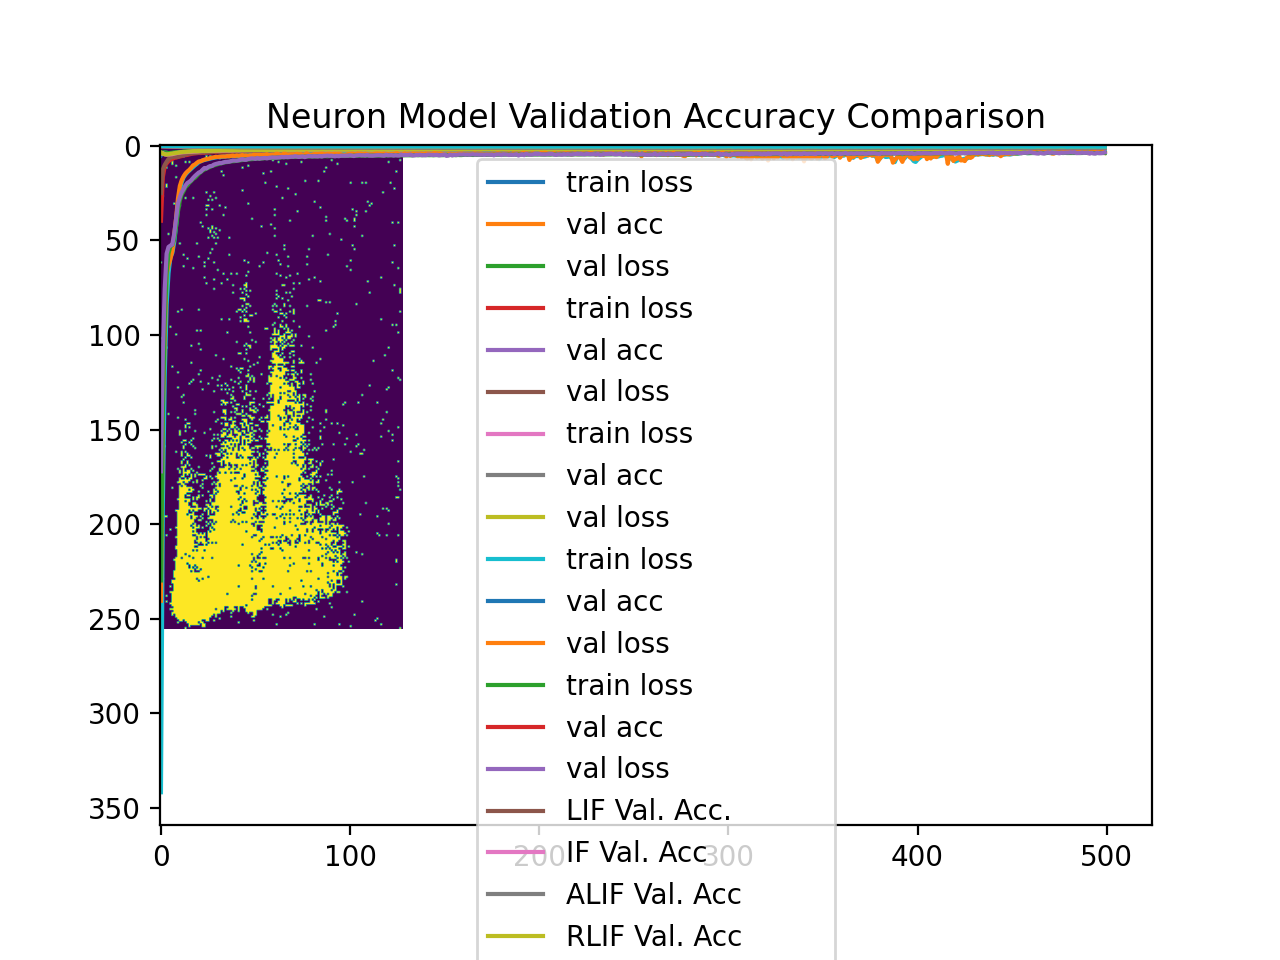

In [5]:
plt.imshow(np.unpackbits(x[0][69], axis=0).T)
plt.show()

In [6]:
y.shape

(25, 256)

## SNN

Here we define a simple feed-forward SNN using Haiku's RNN features, incorporating our
LIF neuron models where activation functions would usually go. Haiku manages all of the state for us, so when we transform the function and get an apply() function we just need to pass the params!

Since spiking neurons have a discrete all-or-nothing activation, in order to do gradient descent we'll have to approximate the derivative of the Heaviside function with something smoother. In this case, we use the SuperSpike surrogate gradient from Zenke & Ganguli 2017.
Also not that we aren't using bias terms on the linear layers and since the inputs are images, we flatten the data before feeding it to the first layer.

Depending on computational constraints, we can use haiku's dynamic unroll to iterate the SNN, or we can use static unroll where the SNN will be unrolled during the JIT compiling process to further increase speed when training on GPU. Note that the static unroll will take longer to compile, but once it runs the iterations per second will be 2x-3x greater than the dynamic unroll.

In [7]:
def lif_snn(x):
    
    x = hk.BatchApply(hk.Linear(128, with_bias=False))(x)
    
    core = hk.DeepRNN([
        snn.LIF((128,), activation=spyx.axn.arctan()),
        hk.Linear(128, with_bias=False),
        snn.LIF((128,), activation=spyx.axn.arctan()),
        hk.Linear(20, with_bias=False),
        snn.LI((20,))
    ])
    
    # static unroll for maximum performance
    spikes, V = hk.dynamic_unroll(core, x, core.initial_state(x.shape[0]), time_major=False, unroll=10)
    
    return spikes, V

In [8]:
def if_snn(x):
    
    x = hk.BatchApply(hk.Linear(128, with_bias=False))(x)
    
    core = hk.DeepRNN([
        snn.IF((128,), activation=spyx.axn.arctan()),
        hk.Linear(128, with_bias=False),
        snn.IF((128,), activation=spyx.axn.arctan()),
        hk.Linear(20, with_bias=False),
        snn.LI((20,))
    ])
    
    # static unroll for maximum performance
    spikes, V = hk.dynamic_unroll(core, x, core.initial_state(x.shape[0]), time_major=False, unroll=10)
    
    return spikes, V

In [9]:
def alif_snn(x):
    
    x = hk.BatchApply(hk.Linear(128, with_bias=False))(x)
    
    core = hk.DeepRNN([
        snn.ALIF((128,), activation=spyx.axn.arctan()),
        hk.Linear(128, with_bias=False),
        snn.ALIF((128,), activation=spyx.axn.arctan()),
        hk.Linear(20, with_bias=False),
        snn.LI((20,))
    ])
    
    # static unroll for maximum performance
    spikes, V = hk.dynamic_unroll(core, x, core.initial_state(x.shape[0]), time_major=False, unroll=10)
    
    return spikes, V

In [10]:
def rlif_snn(x):
    
    x = hk.BatchApply(hk.Linear(128, with_bias=False))(x)
    
    core = hk.DeepRNN([
        snn.RLIF((128,), activation=spyx.axn.arctan()),
        hk.Linear(128, with_bias=False),
        snn.RLIF((128,), activation=spyx.axn.arctan()),
        hk.Linear(20, with_bias=False),
        snn.LI((20,))
    ])
    
    # static unroll for maximum performance
    spikes, V = hk.dynamic_unroll(core, x, core.initial_state(x.shape[0]), time_major=False, unroll=10)
    
    return spikes, V

In [11]:
def mixed_snn(x):
    
    x = hk.BatchApply(hk.Linear(128, with_bias=False))(x)
    
    core = hk.DeepRNN([
        snn.ALIF((128,), activation=spyx.axn.arctan()),
        hk.Linear(128, with_bias=False),
        snn.RLIF((128,), activation=spyx.axn.arctan()),
        hk.Linear(20, with_bias=False),
        snn.LI((20,))
    ])
    
    # static unroll for maximum performance
    spikes, V = hk.dynamic_unroll(core, x, core.initial_state(x.shape[0]), time_major=False, unroll=10)
    
    return spikes, V

In [12]:
key = jax.random.PRNGKey(0)
# Since there's nothing stochastic about the network, we can avoid using an RNG as a param!
lif_SNN = hk.without_apply_rng(hk.transform(lif_snn))
lif_params = lif_SNN.init(rng=key, x=x[0])

In [13]:
key = jax.random.PRNGKey(0)
# Since there's nothing stochastic about the network, we can avoid using an RNG as a param!
if_SNN = hk.without_apply_rng(hk.transform(if_snn))
if_params = if_SNN.init(rng=key, x=x[0])

In [14]:
key = jax.random.PRNGKey(0)
# Since there's nothing stochastic about the network, we can avoid using an RNG as a param!
alif_SNN = hk.without_apply_rng(hk.transform(alif_snn))
alif_params = alif_SNN.init(rng=key, x=x[0])

In [15]:
key = jax.random.PRNGKey(0)
# Since there's nothing stochastic about the network, we can avoid using an RNG as a param!
rlif_SNN = hk.without_apply_rng(hk.transform(rlif_snn))
rlif_params = rlif_SNN.init(rng=key, x=x[0])

(256, 128) (128, 128) (256, 128)
(256, 128) (128, 128) (256, 128)
(256, 128) (128, 128) (256, 128)
(256, 128) (128, 128) (256, 128)


In [16]:
key = jax.random.PRNGKey(0)
# Since there's nothing stochastic about the network, we can avoid using an RNG as a param!
mixed_SNN = hk.without_apply_rng(hk.transform(mixed_snn))
mixed_params = mixed_SNN.init(rng=key, x=x[0])

(256, 128) (128, 128) (256, 128)
(256, 128) (128, 128) (256, 128)


## Gradient Descent

We define a training loop below.

We use the Lion optimizer from Optax, which is a more efficient competitor to the popular Adam. The eval steps and updates are JIT'ed to maximize time spent in optimized GPU code and minimize time spent in higher-level python.

The use of regularizers in the spiking network will be covered in a seperate tutorial.

In [17]:
def gd(SNN, params, dl, epochs=500, schedule=3e-4):
    
    aug = spyx.data.shift_augment(max_shift=16)
    
    Loss = spyx.fn.integral_crossentropy()
    Acc = spyx.fn.integral_accuracy()
    
    opt = optax.chain(
        optax.centralize(),
        optax.lion(learning_rate=schedule)
    )
    # create and initialize the optimizer
    opt_state = opt.init(params)
    grad_params = params
        
    # define and compile our eval function that computes the loss for our SNN
    @jax.jit
    def net_eval(weights, events, targets):
        readout = SNN.apply(weights, events)
        traces, V_f = readout
        return Loss(traces, targets)
        
    # Use JAX to create a function that calculates the loss and the gradient!
    surrogate_grad = jax.value_and_grad(net_eval) 
        
    rng = jax.random.PRNGKey(0)        
    
    # compile the meat of our training loop for speed
    @jax.jit
    def train_step(state, data):
        grad_params, opt_state = state
        events, targets = data # fix this
        events = jnp.unpackbits(events, axis=1) # decompress temporal axis
        # compute loss and gradient
        loss, grads = surrogate_grad(grad_params, aug(events, jax.random.fold_in(rng,jnp.sum(targets))), targets)
        # generate updates based on the gradients and optimizer
        updates, opt_state = opt.update(grads, opt_state, grad_params)
        # return the updated parameters
        new_state = [optax.apply_updates(grad_params, updates), opt_state]
        return new_state, loss
    
    # For validation epochs, do the same as before but compute the
    # accuracy, predictions and losses (no gradients needed)
    @jax.jit
    def eval_step(grad_params, data):
        events, targets = data # fix
        events = jnp.unpackbits(events, axis=1)
        readout = SNN.apply(grad_params, events)
        traces, V_f = readout
        acc, pred = Acc(traces, targets)
        loss = Loss(traces, targets)
        return grad_params, jnp.array([acc, loss])
        
    
    val_data = dl.val_epoch()
    
    # Here's the start of our training loop!
    @scan_tqdm(epochs)
    def epoch(epoch_state, epoch_num):
        curr_params, curr_opt_state = epoch_state
        
        shuffle_rng = jax.random.fold_in(rng, epoch_num)
        train_data = dl.train_epoch(shuffle_rng)
        
        # train epoch
        end_state, train_loss = jax.lax.scan(
            train_step,# func
            [curr_params, curr_opt_state],# init
            train_data,# xs
            train_data.obs.shape[0]# len
        )
        
        new_params, _ = end_state
            
        # val epoch
        _, val_metrics = jax.lax.scan(
            eval_step,# func
            new_params,# init
            val_data,# xs
            val_data.obs.shape[0]# len
        )

        
        return end_state, jnp.concatenate([jnp.expand_dims(jnp.mean(train_loss),0), jnp.mean(val_metrics, axis=0)])
    # end epoch
    
    # epoch loop
    final_state, metrics = jax.lax.scan(
        epoch,
        [grad_params, opt_state], # metric arrays
        jnp.arange(epochs), # 
        epochs # len of loop
    )
    
    final_params, _ = final_state
    
                
    # return our final, optimized network.       
    return final_params, metrics

In [18]:
def test_gd(SNN, params, dl):

    Loss = spyx.fn.integral_crossentropy()
    Acc = spyx.fn.integral_accuracy()
    
    @jax.jit
    def test_step(params, data):
        events, targets = data
        events = jnp.unpackbits(events, axis=1)
        readout = SNN.apply(params, events)
        traces, V_f = readout
        acc, pred = Acc(traces, targets)
        loss = Loss(traces, targets)
        return params, [acc, loss, pred, targets]
    
    test_data = dl.test_epoch()
    
    _, test_metrics = jax.lax.scan(
            test_step,# func
            params,# init
            test_data,# xs
            test_data.obs.shape[0]# len
    )
    
    acc = jnp.mean(test_metrics[0])
    loss = jnp.mean(test_metrics[1])
    preds = jnp.array(test_metrics[2]).flatten()
    tgts = jnp.array(test_metrics[3]).flatten()
    return acc, loss, preds, tgts

## Training Time

We'll train the network for 50 epochs since SHD is more difficult than MNIST.

The SHD dataloader for Spyx has built-in leave-one-group-out cross validation. This is becuase the test set for SHD has two unseen speakers, so when we train our model we need to make it robust to speakers it isn't training on in the hopes of improving generalization accuracy.

In [19]:
lif_grad_params, lif_metrics = gd(lif_SNN, lif_params, shd_dl, epochs=500, schedule=1e-4) # 1:09

  0%|          | 0/500 [00:00<?, ?it/s]

In [20]:
print("Performance: train_loss={}, val_acc={}, val_loss={}".format(*lif_metrics[-1]))

Performance: train_loss=1.735169529914856, val_acc=0.9127604365348816, val_loss=1.7500375509262085


In [21]:
plt.plot(lif_metrics, label=["train loss", "val acc", "val loss"])
plt.title("LIF Neuron Model")
plt.legend()
plt.show()

In [22]:
if_grad_params, if_metrics = gd(if_SNN, if_params,
                                shd_dl, epochs=500, schedule=1e-4) # 0:56 seconds!

  0%|          | 0/500 [00:00<?, ?it/s]

In [23]:
print("Performance: train_loss={}, val_acc={}, val_loss={}".format(*if_metrics[-1]))

Performance: train_loss=2.254917621612549, val_acc=0.6901041865348816, val_loss=2.191420555114746


In [24]:
plt.plot(if_metrics, label=["train loss", "val acc", "val loss"])
plt.title("IF Neuron Model")
plt.legend()
plt.show()

In [25]:
alif_grad_params, alif_metrics = gd(alif_SNN, alif_params,
                                    shd_dl, epochs=500, schedule=2e-4) # 1:43

  0%|          | 0/500 [00:00<?, ?it/s]

In [26]:
print("Performance: train_loss={}, val_acc={}, val_loss={}".format(*alif_metrics[-1]))

Performance: train_loss=1.7228007316589355, val_acc=0.9270833730697632, val_loss=1.7260994911193848


In [27]:
plt.plot(alif_metrics, label=["train loss", "val acc", "val loss"])
plt.title("ALIF Neuron Model")
plt.legend()
plt.show()

In [41]:
rlif_grad_params, rlif_metrics = gd(rlif_SNN, rlif_params,
                                    shd_dl, epochs=500, schedule=3e-4) # 1:13

(256, 128) (128, 128) (256, 128)
(256, 128) (128, 128) (256, 128)
(256, 128) (128, 128) (256, 128)
(256, 128) (128, 128) (256, 128)


  0%|          | 0/500 [00:00<?, ?it/s]

In [40]:
print("Performance: train_loss={}, val_acc={}, val_loss={}".format(*rlif_metrics[-1]))

Performance: train_loss=5.1703104972839355, val_acc=0.4921875, val_loss=5.135010242462158


In [30]:
plt.plot(rlif_metrics, label=["train loss", "val acc", "val loss"])
plt.title("RLIF Neuron Model")
plt.legend()
plt.show()

In [31]:
mixed_grad_params, mixed_metrics = gd(mixed_SNN, mixed_params,
                                      shd_dl, epochs=500, schedule=1e-4) # 1:26

(256, 128) (128, 128) (256, 128)
(256, 128) (128, 128) (256, 128)


  0%|          | 0/500 [00:00<?, ?it/s]

In [32]:
print("Performance: train_loss={}, val_acc={}, val_loss={}".format(*mixed_metrics[-1]))

Performance: train_loss=3.7586870193481445, val_acc=0.37890625, val_loss=3.425750494003296


In [33]:
plt.plot(mixed_metrics, label=["train loss", "val acc", "val loss"])
plt.title("ALIF+RLIF Neuron Model")
plt.legend()
plt.show()

In [34]:
plt.plot(lif_metrics[:,1], label="LIF Val. Acc.")
plt.plot(if_metrics[:,1], label="IF Val. Acc")
plt.plot(alif_metrics[:,1], label="ALIF Val. Acc")
plt.plot(rlif_metrics[:,1], label="RLIF Val. Acc")
plt.plot(mixed_metrics[:,1], label="ALIF+RLIF Val. Acc")

plt.title("Neuron Model Validation Accuracy Comparison")
plt.legend()
plt.show()

## Evaluation Time

Now we'll run the network on the test set and see what happens:

In [35]:
acc, loss, preds, tgts = test_gd(rlif_SNN, rlif_grad_params, shd_dl)
print("Accuracy:", acc, "Loss:", loss)

(256, 128) (128, 128) (256, 128)
(256, 128) (128, 128) (256, 128)
Accuracy: 0.38720703 Loss: 3.6741865


<IPython.core.display.Javascript object>


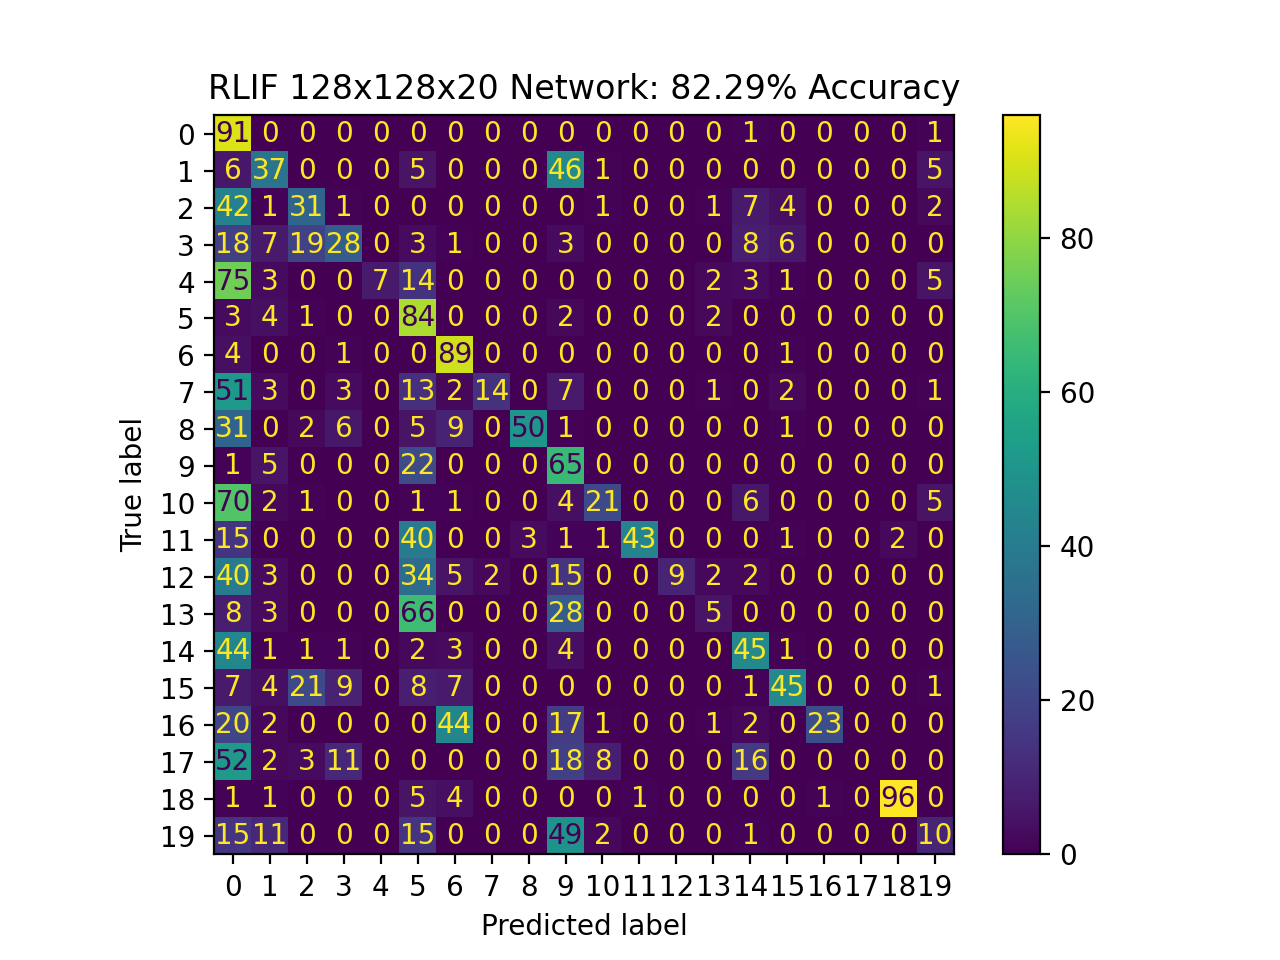

In [36]:
cm = confusion_matrix(tgts, preds)
ConfusionMatrixDisplay(cm).plot()
plt.title("RLIF 128x128x20 Network: 82.29% Accuracy")
plt.show()